<a href="https://colab.research.google.com/github/cincinnatilibrary/collection-analysis/blob/master/reports/tweet_a_random_title.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHPL - Collection Analysis - **tweet a random title's data**
<img src="https://ilsweb.cincinnatilibrary.org/img/CHPL_Brandmark_Primary.png" alt="CHPL" title="CHPL" width="300"/>

This is what can feed a twitter, "tweet a random title" feed

Data sources / Documentation:

* https://ilsweb.cincinnatilibrary.org/collection-analysis/

In [2]:
# !pip install -U tweepy

In [11]:
from getpass import getpass
import requests
import json
from uuid import uuid4
from time import sleep
from IPython.display import Image
import pandas as pd
import altair as alt
import re
import imghdr
from IPython.display import Image
import tweepy

In [4]:
bc_key = getpass('bc api key:')

bc api key:··········


In [5]:
chpl_collection_url = 'https://ilsweb.cincinnatilibrary.org/collection-analysis/current_collection'

In [6]:
# get a distribution of titles in the CHPL collection by decade
sql = """\
select
  cast(
    (cast(bib.publish_year as INTEGER) / 10) AS TEXT
  ) || 'X' as "publish decade",
  -- (cast(bib.publish_year as INTEGER) / 10) * 10 as "publish decade" ,
  count(bib.bib_record_num) as "count titles"
from
  bib
  join item on item.bib_record_num = bib.bib_record_num
where
  bib.publish_year is not null
  and bib.publish_year != ''
  and bib.publish_year >= 1830
  and bib.publish_year <= cast(strftime('%Y', 'now') as INTEGER)
  and bib.isbn is not null
group by
  1
having
  count(
    case
      when item.item_status_code IN ('-', 'd', 't') then 1
      else 0
    end
  ) > 1
order by
  1
"""

try:
    r = requests.get(
        chpl_collection_url + '.json',
        params={
            'sql': sql,
            '_shape': 'array'
        }
    )
    
    df = pd.read_json(r.text)
    
except:
    pass

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('publish decade', axis=alt.Axis(labelAngle=-45)), # sort='-y' ),
    y=alt.Y('count titles', ),
    tooltip=['publish decade', 'count titles'],
    # color='op_name',
).properties(
    width=600,
    title='CHPL Collection: Titles in Collection Published By Decade (having an ISBN)',

).configure_title(
    # fontSize=20,
    # anchor='start',
)

chart.display()
# Image('visualization.png')

alt.Chart(...)

.
[
  {
    "query_guid": "bfb95b19-43dd-48c0-b47d-46472eddfebe",
    "time_stamp": "2022-01-28 20:56:59",
    "bib_record_num": 2333668,
    "count_available": 2,
    "count_total_items": 2,
    "sum_circulation": 29,
    "last_circ_date": "2012-09-10",
    "last_circ_month": "9/2012",
    "item_format": "Book",
    "callnumber": "813.52 b972 zh2",
    "creation_date": "2012-06-21",
    "record_last_updated": "2018-10-12",
    "isbn": "0805774599",
    "best_author": "Holtsmark, Erling B., 1936-",
    "best_title": "Edgar Rice Burroughs",
    "publisher": "Twayne Publishers,",
    "publish_year": 1986,
    "bib_level_callnumber": "813.52 b972 zh2   ",
    "indexed_subjects": "burroughs edgar rice     1875     1950 criticism and interpretation,criticism and interpretation burroughs edgar rice 1875     1950,tarzan fictitious character"
  }
]
https://covers.openlibrary.org/b/isbn/0805774599-L.jpg



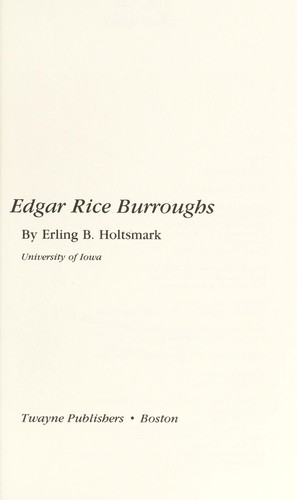

In [24]:
sql = """\
with bib_data as (
  with random_bib as (
    select
      :guid as query_guid,
      datetime('now', 'localtime') as time_stamp,
      bib.bib_record_num
    from
      bib
    where
      bib.publish_year is not null
      and bib.publish_year != ''
      and bib.publish_year >= 1830
      and bib.publish_year <= cast(strftime('%Y', 'now') as INTEGER)
      and bib.isbn is not null
    order by
      random()
    limit
      1
  )
  select
    r.query_guid,
    r.time_stamp,
    r.bib_record_num,
    count(
      case
        when item.item_status_code IN ('-', 'd', 't') then 1
        else 0
      end
    ) as count_available,
    count(item.item_record_num) as count_total_items,
    (
      sum(item.checkout_total) + sum(item.renewal_total)
    ) as sum_circulation,
    max(
      coalesce(
        item.last_checkin_date,
        item.checkout_date,
        item.last_checkout_date
      )
    ) as last_circ_date,
    -- ltrim(strftime('%m/%Y', last_circ_date), '0') as last_circ_month,
    -- max(item.item_format) as item_format,
    (
      select
        group_concat(item_format, ', ')
      from
        (
          select
            distinct item.item_format
          from
            item
          where
            bib_record_num = r.bib_record_num
            and item.item_status_code IN ('-', 'd', 't')
          order by
            item_format
        )
    ) as item_format,
    max(item.item_callnumber) as callnumber
  from
    random_bib as r -- join bib on bib.bib_record_num = r.bib_record_num
    join item on item.bib_record_num = r.bib_record_num
  group by
    1,
    2,
    3
  having
    count(
      case
        when item.item_status_code IN ('-', 'd', 't') then 1
        else 0
      end
    ) > 1
)
select
  d.query_guid,
  d.time_stamp,
  d.bib_record_num,
  d.count_available,
  d.count_total_items,
  d.sum_circulation,
  d.last_circ_date,
  ltrim(strftime('%m/%Y', d.last_circ_date), '0') as last_circ_month,
  d.item_format,
  callnumber,
  bib.*
from
  bib_data as d
  join bib on bib.bib_record_num = d.bib_record_num
"""

# Note: the random search may not return a value, so loop up to 100 times
# Note: we're sending a guid so that we can make sure the query is not being cached
count = 100
while count:
  count -= 1
  print('.', end='')

  try:
      r = requests.get(
          chpl_collection_url + '.json',
          params={
              'sql': sql,
              '_shape': 'array',
              'guid': str(uuid4())
          }
      )
      if len(r.json()) > 0:
        break
      
      df = pd.read_json(r.text)
      
  except:
      pass

  sleep(1)

print(
    "\n",
    json.dumps(r.json(), indent=2),
    sep=""
)

try:
  r_open_library = requests.get(
    'https://covers.openlibrary.org/b/isbn/{}-L.jpg'.format(r.json()[0]['isbn'])
  )
  if imghdr.what(None, h=r_open_library.content) == 'jpeg':
      print('https://covers.openlibrary.org/b/isbn/{}-L.jpg'.format(r.json()[0]['isbn']))
      # break
  else:
    print('No Image Found', end='')
except:
  pass

try:
  r_title = requests.get(
    url = "https://api.bibliocommons.com/v1/titles/{}".format(
        str(r.json()[0]['bib_record_num']) + "170"
    ),
    params={
      "api_key": bc_key
    }
  )

  print(r_title.json()['title']['description'])
  # print(r_title.status_code, json.dumps(r_title.json(), indent=2), sep="\n")
except:
  pass

Image(r_open_library.content)

In [25]:
# 280 characters max (includes a link, representing 23 characters ... see below)
# A URL of any length will be altered to 23 characters, 
# even if the link itself is less than 23 characters long, 
# character count will reflect this.
tweet = ""
tweet += """{}""".format(
    str(r.json()[0]['best_title']).title(),
)
if r.json()[0]['best_author'] is not None:
    tweet += """—{}\n""".format(str(r.json()[0]['best_author']))
else:
    tweet += """\n"""

# regex to replace excess whitespace
re_compress_space = re.compile("\s+")

tweet += """{}
{} | {}
items: {} | circs: {}""".format(
    str(r.json()[0]['publish_year']),
    str(r.json()[0]['item_format']),
    re_compress_space.sub(" ", str(r.json()[0]['callnumber'])),
    str(r.json()[0]['count_available']),
    str(r.json()[0]['sum_circulation']),
)

if r.json()[0]['last_circ_month'] is not None:
    tweet += """ | last circ: {}\n""".format(r.json()[0]['last_circ_month'])
else:
    tweet += """\n"""

extra = ""
if r.json()[0]['indexed_subjects'] is not None:
    subject = re_compress_space.sub(" ", str(r.json()[0]['indexed_subjects']))
    if len(subject) <= (253 - len(tweet)):
      extra += subject
      extra += "\n"
    else:
      extra += subject[:253 - len(tweet)]
      extra += "... "

extra += """https://cincinnatilibrary.bibliocommons.com/v2/record/S170C{}""".format(
    str(r.json()[0]['bib_record_num'])
)

print(tweet+extra)
print(len(tweet+extra))

Edgar Rice Burroughs—Holtsmark, Erling B., 1936-
1986
Book | 813.52 b972 zh2
items: 2 | circs: 29 | last circ: 9/2012
burroughs edgar rice 1875 1950 criticism and interpretation,criticism and interpretation burroughs edgar rice 1875 1950,tarzan fictitio... https://cincinnatilibrary.bibliocommons.com/v2/record/S170C2333668
323


In [13]:
json_twitter_creds_text = getpass('enter json_twitter_creds:')
json_twitter_creds = json.loads(json_twitter_creds_text)

enter json_twitter_creds:··········


In [26]:
client = tweepy.Client(
    consumer_key=json_twitter_creds['consumer_key'], 
    consumer_secret=json_twitter_creds['consumer_secret'],
    access_token=json_twitter_creds['access_token'], 
    access_token_secret=json_twitter_creds['access_token_secret']
)

response = client.create_tweet(
    text=tweet+extra
)
print(f"https://twitter.com/user/status/{response.data['id']}")

https://twitter.com/user/status/1487243718574981125
